# **Projet Modélisation du risque de crédit**


## **Partie analyse exploratoire**

### Chargement des packages

In [ ]:
import pandas as pd
from google.colab import drive
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


### Chargement du dataset

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
chemin_fichier = '/content/drive/MyDrive/Loan_Data.csv'
loan_base = pd.read_csv(chemin_fichier, sep=",")
loan_base

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [ ]:
type(loan_base)

pandas.core.frame.DataFrame

In [ ]:
loan_base.isna().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

In [ ]:
loan_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [ ]:
list(loan_base.columns)

['customer_id',
 'credit_lines_outstanding',
 'loan_amt_outstanding',
 'total_debt_outstanding',
 'income',
 'years_employed',
 'fico_score',
 'default']

In [ ]:
loan_drop = loan_base.drop(columns=['customer_id'])
loan_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   credit_lines_outstanding  10000 non-null  int64  
 1   loan_amt_outstanding      10000 non-null  float64
 2   total_debt_outstanding    10000 non-null  float64
 3   income                    10000 non-null  float64
 4   years_employed            10000 non-null  int64  
 5   fico_score                10000 non-null  int64  
 6   default                   10000 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 547.0 KB


In [ ]:
loan_drop2 = loan_drop.drop(columns=['default'])
loan_drop2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   credit_lines_outstanding  10000 non-null  int64  
 1   loan_amt_outstanding      10000 non-null  float64
 2   total_debt_outstanding    10000 non-null  float64
 3   income                    10000 non-null  float64
 4   years_employed            10000 non-null  int64  
 5   fico_score                10000 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 468.9 KB


In [ ]:
loan_drop2.describe()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700
std,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906
min,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000
25%,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000
50%,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000
75%,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000
max,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000


In [ ]:
# On crée un tableau pour stocker les résultats
resultats_tests = pd.DataFrame(columns=['Variable', 'Statistique de test', 'p-value', 'Suit loi normale (5%)'])

# Boucle pour effectuer le shapiro test sur chaque variable:
for colonne in loan_drop.columns:
    # Effectuez le test de normalité de Shapiro-Wilk
    statistique, p_value = shapiro(loan_drop[colonne])

    # Ajoutez les résultats au tableau
    suit_loi_normale = 'Oui' if p_value > 0.05 else 'Non'
    resultats_tests = resultats_tests.append({
        'Variable': colonne,
        'Statistique de test': statistique,
        'p-value': p_value,
        'Suit loi normale (5%)': suit_loi_normale
    }, ignore_index=True)

# Affichez le tableau des résultats
resultats_tests

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
<ipython-input-32-5f78cb42ebc8>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultats_tests = resultats_tests.append({
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
<ipython-input-32-5f78cb42ebc8>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultats_tests = resultats_tests.append({
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
<ipython

,Variable,Statistique de test,p-value,Suit loi normale (5%)
0,credit_lines_outstanding,0.771893,0.000000e+00,Non
1,loan_amt_outstanding,0.990212,1.187918e-25,Non
2,total_debt_outstanding,0.872092,0.000000e+00,Non
3,income,0.999785,4.268782e-01,Oui
4,years_employed,0.964376,5.324934e-44,Non
5,fico_score,0.999463,4.225538e-03,Non
6,default,0.472681,0.000000e+00,Non


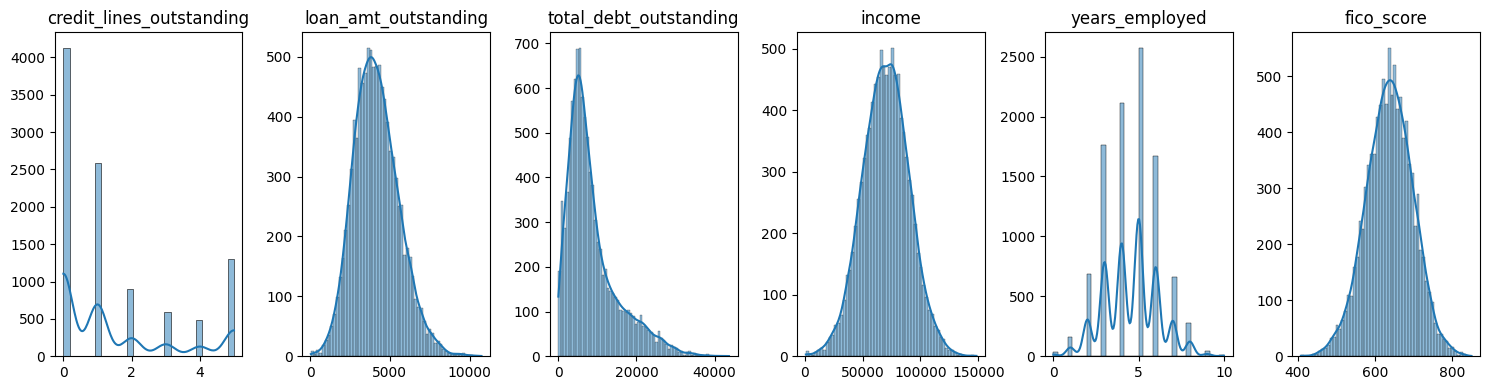

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(loan_drop2.columns), figsize=(15, 4))

for i, colonne in enumerate(loan_drop2.columns):
    sns.histplot(loan_drop2[colonne], ax=axes[i], kde=True)
    axes[i].set_title(colonne)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Ajustez l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichez les histogrammes
plt.show()

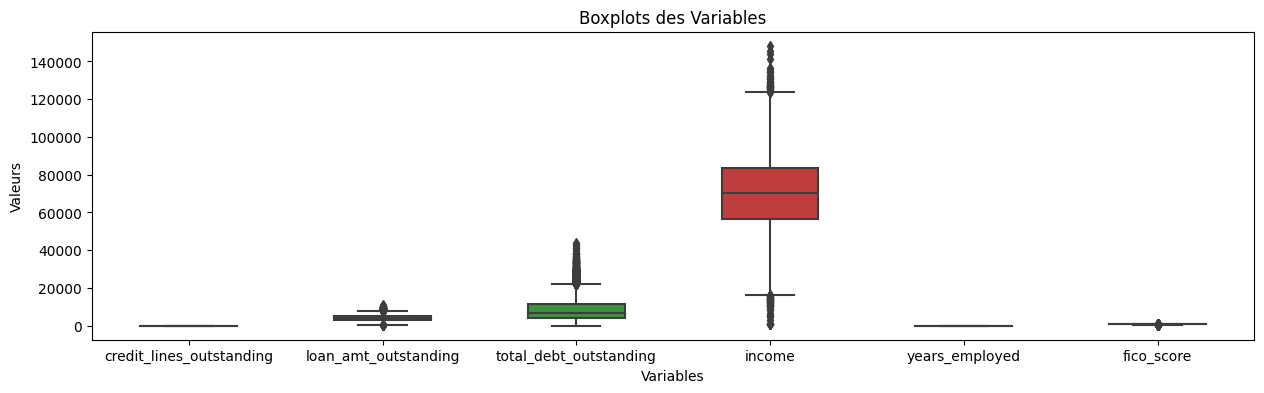

In [ ]:
plt.figure(figsize=(15, 4))

sns.boxplot(data=loan_drop2, width=0.5)

plt.xlabel('Variables')
plt.ylabel('Valeurs')

plt.title('Boxplots des Variables')

plt.show()

In [ ]:
loan_base.default.describe()

count    10000.000000
mean         0.185100
std          0.388398
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

In [ ]:
loan_base.default.unique()

array([0, 1])

In [ ]:
loan_base.default.value_counts()

0    8149
1    1851
Name: default, dtype: int64

In [ ]:
pd.crosstab(loan_base.default, "freq", normalize=True)

col_0,freq
default,
0,0.8149
1,0.1851


<Axes: xlabel='default'>

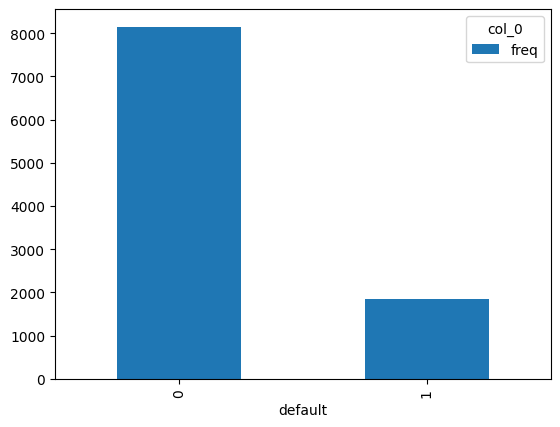

In [ ]:
t = pd.crosstab(loan_base.default, "freq")
t.plot.bar()

In [ ]:
scipy.stats.chisquare(t)

Power_divergenceResult(statistic=array([3966.4804]), pvalue=array([0.]))

<Axes: >

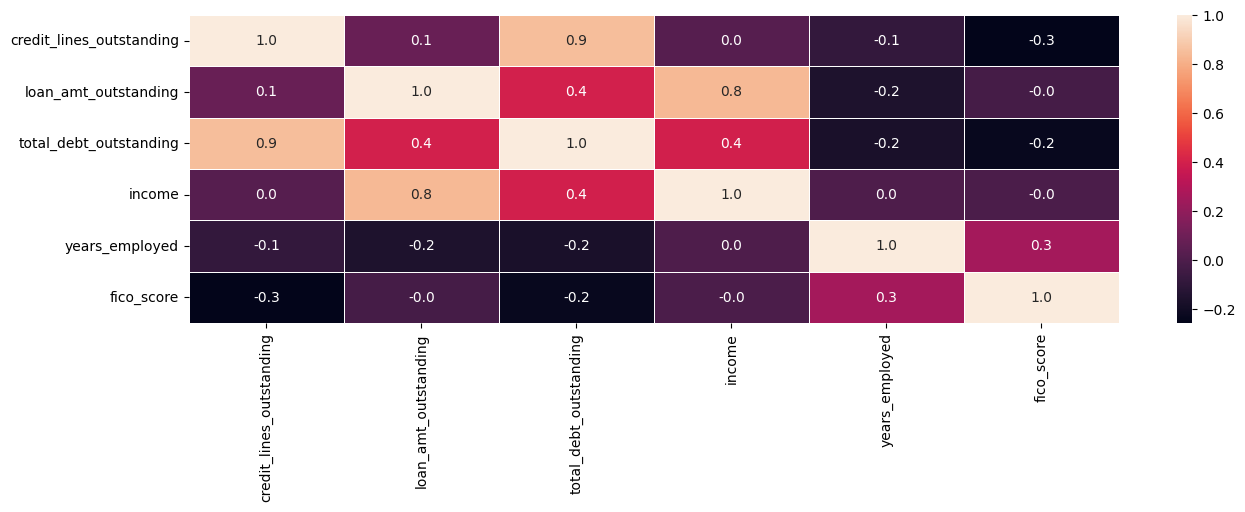

In [ ]:
#correlation map
f,ax = plt.subplots(figsize=(15, 4))
sns.heatmap(loan_drop2.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

<Axes: >

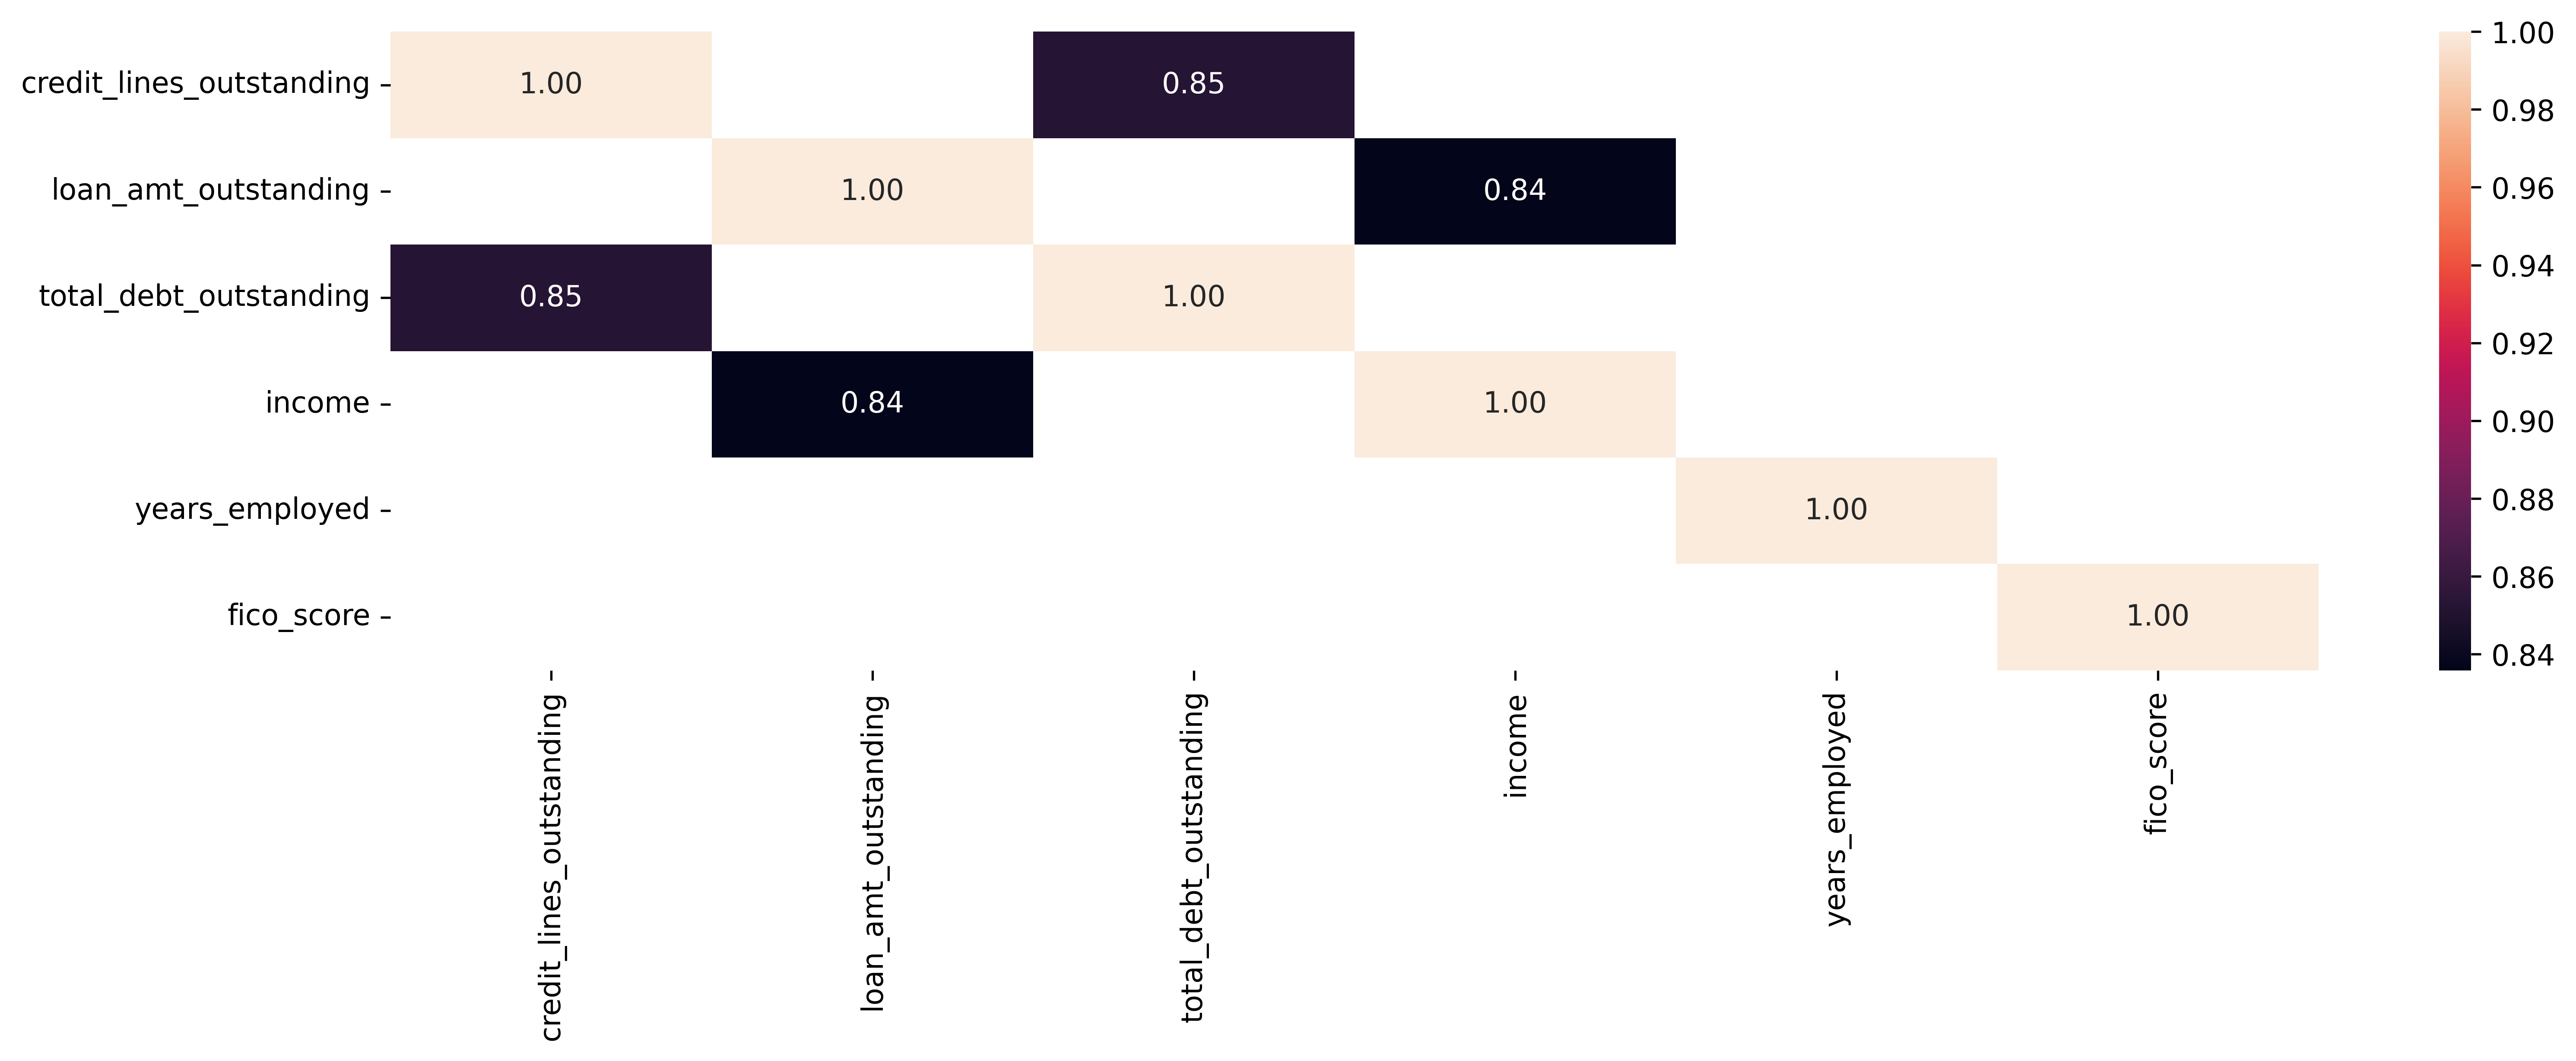

In [ ]:
m_corr = loan_drop2.corr()
fig = plt.figure(figsize=(15,4), dpi = 480)
sns.heatmap(m_corr[abs(m_corr)>=0.50],annot = True, fmt = '.2f')

In [ ]:
loan_base.credit_lines_outstanding.value_counts()

0    4128
1    2590
5    1297
2     902
3     599
4     484
Name: credit_lines_outstanding, dtype: int64

In [ ]:
# Séparer les variables discrètes des variables continues
discrete_variable = loan_base['credit_lines_outstanding']
continuous_variables = loan_base.drop(['customer_id', 'credit_lines_outstanding', 'default'], axis=1)

In [ ]:
# Standardisation des variables continues
scaler = StandardScaler()
scaled_continuous_variables = pd.DataFrame(scaler.fit_transform(continuous_variables), columns=continuous_variables.columns)

In [ ]:
#Concaténation des variables discrètes, continues standardisées et cible
scaled_base = pd.concat([discrete_variable, scaled_continuous_variables, loan_base['default']], axis=1)
scaled_base

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,0,0.747096,-0.724848,0.398555,0.285425,-0.536770,0
1,5,-1.548375,-0.073967,-2.161876,-1.629325,-1.080832,1
2,0,-0.560509,-1.009696,-0.207919,-0.352825,-0.586230,0
3,0,0.427045,-0.938184,0.215083,0.285425,-0.421363,0
4,1,-1.979733,-1.048780,-2.321314,0.923675,-0.108115,0
...,...,...,...,...,...,...,...
9995,0,-0.792238,-0.930336,-1.362562,0.285425,0.980009,0
9996,1,-0.009454,-0.492053,0.494719,2.200176,-0.371903,0
9997,2,-0.753840,-0.589396,-1.586712,0.285425,-0.685150,0
9998,0,-0.612649,-1.158293,-0.952136,-1.629325,0.155673,0


In [ ]:
#Division de l'échantillon en train, validation et test
train_base, test_base = train_test_split(scaled_base, test_size=0.2, random_state=1)
train_base, val_base = train_test_split(train_base, test_size=0.15, random_state=1)

In [ ]:
#Séparation des variables indépendantes (X) et de la variable cible (y)
X_train = train_base.drop('default', axis=1)
y_train = train_base['default']
X_val = val_base.drop('default', axis=1)
y_val = val_base['default']
X_test = test_base.drop('default', axis=1)
y_test = test_base['default']

In [ ]:
# Redressage l'échantillon train par oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Maintenant, X_train_resampled et y_train_resampled peuvent être utilisés pour l'entraînement des différents modèles

In [ ]:
X_train_resampled

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score
0,0,-0.258741,-0.838220,-1.244146,-1.629325,-1.328132
1,1,-0.189751,-0.378812,0.662864,2.838426,-0.404876
2,5,-0.378145,1.245952,-0.548310,-0.991075,0.007292
3,0,-0.634033,-0.714794,0.098844,-1.629325,0.485407
4,1,-1.827551,-0.774366,-1.611915,0.285425,-0.668664
...,...,...,...,...,...,...
11087,4,-0.677040,0.449248,-0.906280,-0.352825,0.122699
11088,4,-1.257624,0.093524,-1.391484,0.285425,1.276770
11089,3,0.890783,1.101996,0.410876,-0.352825,-0.882991
11090,5,-0.453135,1.635329,-0.107439,0.285425,-0.207035


In [ ]:
# Concaténation des données resamplées pour créer un DataFrame avec la variable cible
resampled_base = pd.DataFrame(X_train_resampled.copy(), columns=X_train.columns)
resampled_base['default'] = y_train_resampled
resampled_base

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,0,-0.258741,-0.838220,-1.244146,-1.629325,-1.328132,0
1,1,-0.189751,-0.378812,0.662864,2.838426,-0.404876,0
2,5,-0.378145,1.245952,-0.548310,-0.991075,0.007292,1
3,0,-0.634033,-0.714794,0.098844,-1.629325,0.485407,0
4,1,-1.827551,-0.774366,-1.611915,0.285425,-0.668664,0
...,...,...,...,...,...,...,...
11087,4,-0.677040,0.449248,-0.906280,-0.352825,0.122699,1
11088,4,-1.257624,0.093524,-1.391484,0.285425,1.276770,1
11089,3,0.890783,1.101996,0.410876,-0.352825,-0.882991,1
11090,5,-0.453135,1.635329,-0.107439,0.285425,-0.207035,1


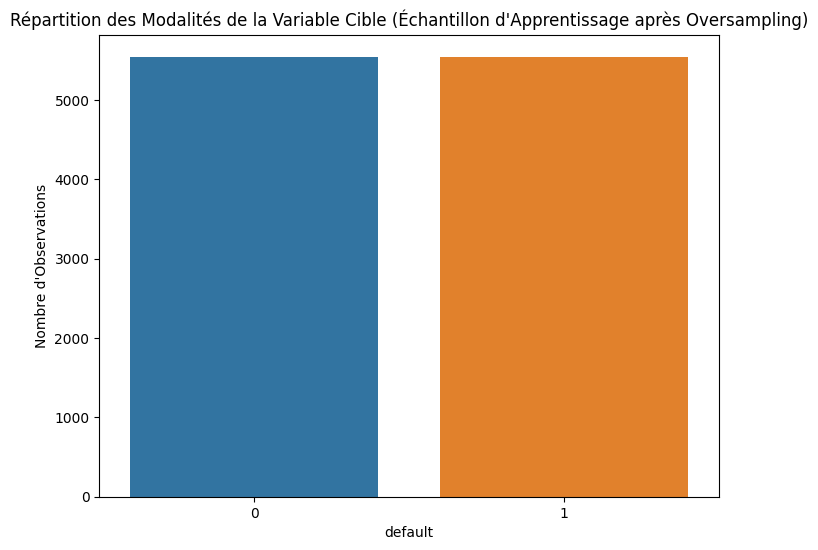

In [ ]:
# Tracer un diagramme à barres pour la répartition des modalités de la variable cible
plt.figure(figsize=(8, 6))
sns.countplot(x='default', data=resampled_base)
plt.title('Répartition des Modalités de la Variable Cible (Échantillon d\'Apprentissage après Oversampling)')
plt.xlabel('default')
plt.ylabel('Nombre d\'Observations')
plt.show()

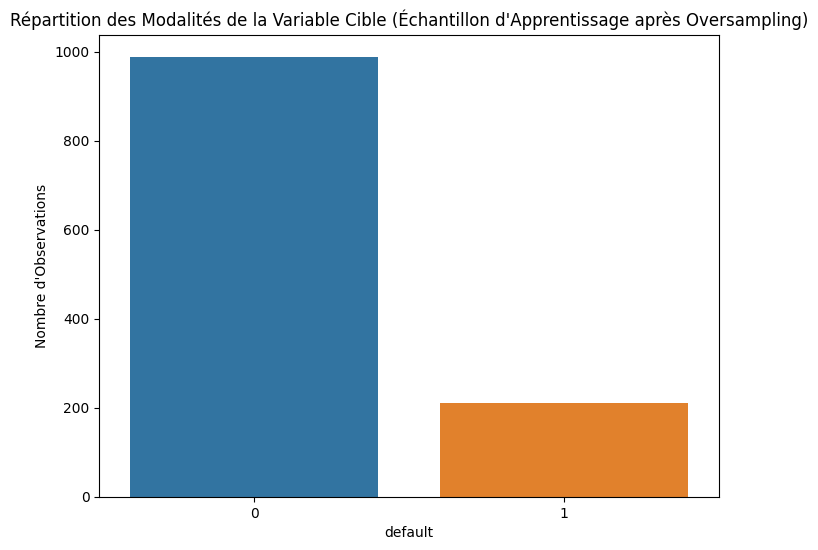

In [ ]:
# Tracer un diagramme à barres pour la répartition des modalités de la variable cible
plt.figure(figsize=(8, 6))
sns.countplot(x='default', data=val_base)
plt.title('Répartition des Modalités de la Variable Cible (Échantillon d\'Apprentissage après Oversampling)')
plt.xlabel('default')
plt.ylabel('Nombre d\'Observations')
plt.show()

#**Modélisation**

##**Random Forest**

In [ ]:
# Définition du modèle Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Définition de la grille d'hyperparamètres à rechercher
param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [None, 1, 2, 3],
    'min_samples_split': [2, 5, 10, 50, 100],
    'min_samples_leaf': [1, 2, 4]
}

# Recherche d'hyperparamètres avec GridSearchCV et validation croisée
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_val, y_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 1, 2, 3],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10, 50, 100],
                         'n_estimators': [10, 20, 50, 100]},
             scoring='accuracy')

In [ ]:
# Afficher les meilleurs paramètres
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Meilleurs paramètres :", best_params)# Meilleur paramètres
print("Meilleur score : ", best_score) # Meilleur score

Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
Meilleur score :  0.9891666666666665


In [ ]:
pd.DataFrame(grid_search.cv_results_
             ).sort_values(by='rank_test_score'
                           ).head(10) # Résultats de la recherche

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.034358,0.001691,0.004669,0.000704,None,1,10,10,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.000000,0.979167,0.991667,0.983333,0.991667,0.989167,0.007265,1
2,0.103163,0.003713,0.005808,0.000032,None,1,2,50,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.000000,0.983333,0.979167,0.983333,0.991667,0.987500,0.007454,2
3,0.200433,0.004726,0.009899,0.000641,None,1,2,100,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.000000,0.979167,0.979167,0.983333,0.991667,0.986667,0.008079,3
6,0.103177,0.004591,0.006373,0.000700,None,1,5,50,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.000000,0.979167,0.979167,0.983333,0.991667,0.986667,0.008079,3
9,0.064478,0.002842,0.005476,0.000311,None,1,10,20,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.995833,0.979167,0.987500,0.983333,0.987500,0.986667,0.005528,3
0,0.024396,0.001515,0.003268,0.000098,None,1,2,10,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.000000,0.979167,0.979167,0.979167,0.991667,0.985833,0.008580,6
22,0.106365,0.004501,0.006102,0.000181,None,2,2,50,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",1.000000,0.979167,0.979167,0.979167,0.991667,0.985833,0.008580,6
20,0.022556,0.000770,0.003265,0.000182,None,2,2,10,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.995833,0.983333,0.979167,0.979167,0.991667,0.985833,0.006770,6
1,0.043137,0.000968,0.003903,0.000061,None,1,2,20,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.995833,0.983333,0.979167,0.979167,0.987500,0.985000,0.006236,9
27,0.199546,0.005334,0.009380,0.000258,None,2,5,100,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",1.000000,0.975000,0.979167,0.983333,0.987500,0.985000,0.008580,9


In [ ]:
# Création du meilleur modèle avec les paramètres trouvés
best_rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

In [ ]:
# Évaluation avec validation croisée
cv_scores = cross_val_score(best_rf_model, X_val, y_val, cv=5, scoring='accuracy')
print("Précision moyenne avec validation croisée :", np.mean(cv_scores))

Précision moyenne avec validation croisée : 0.9891666666666665


In [ ]:
# Entraînement du modèle sur l'échantillon d'entraînement
best_rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(min_samples_split=10, n_estimators=10, random_state=42)

In [ ]:
# Prédiction sur l'échantillon d'entraînement et de test
y_train_pred = best_rf_model.predict(X_train_resampled)
y_test_pred = best_rf_model.predict(X_test)

# Évaluation de la précision du modèle
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Précision sur l'échantillon d'entraînement :", train_accuracy)
print("Précision sur l'échantillon de test :", test_accuracy)

Précision sur l'échantillon d'entraînement : 0.9995492246664263
Précision sur l'échantillon de test : 0.996


In [ ]:
# Matrice de confusion
conf_matrix_train = confusion_matrix(y_train_resampled, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

print("Matrice de confusion (entraînement) :\n", conf_matrix_train)
print("Matrice de confusion (test) :\n", conf_matrix_test)

Matrice de confusion (entraînement) :
 [[5541    5]
 [   0 5546]]
Matrice de confusion (test) :
 [[1609    5]
 [   3  383]]


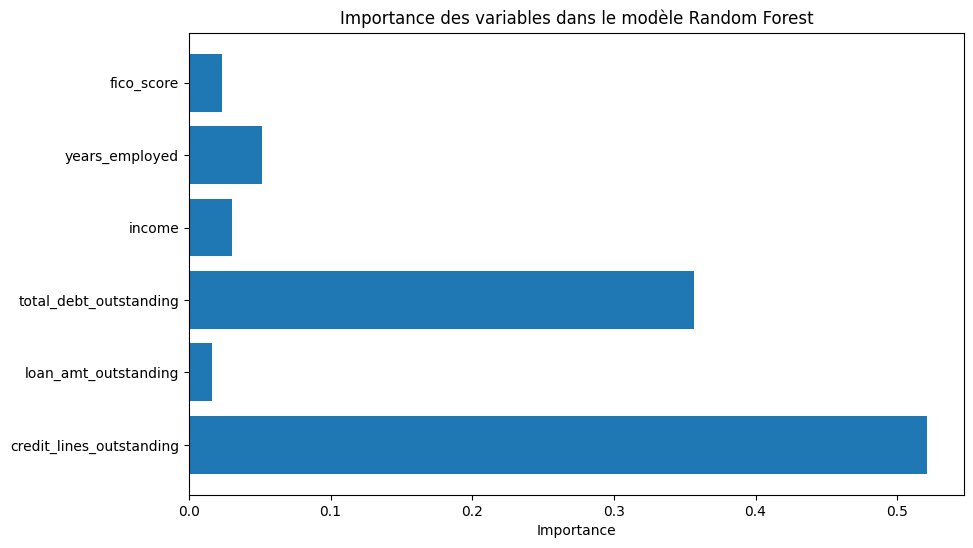

In [ ]:
# Importance des variables
feature_importances = best_rf_model.feature_importances_
features = X_train.columns

# Tracé du graphique d'importance des variables
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.title('Importance des variables dans le modèle Random Forest')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,\
    confusion_matrix, classification_report,ConfusionMatrixDisplay
#création d'une fonction d'évaluation

def evaluate_model(model, X_test, y_test):
    # On prédit les valeurs de la variable cible pour les données de test
    y_pred = model.predict(X_test)

    # On calcule l'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %.2f' % accuracy)

    # On calcule la matrice de confusion
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

    # On calcule le rapport de classification

    report = classification_report(y_test, y_pred)
    print(report)
    return None

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1614
           1       0.99      0.99      0.99       386

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



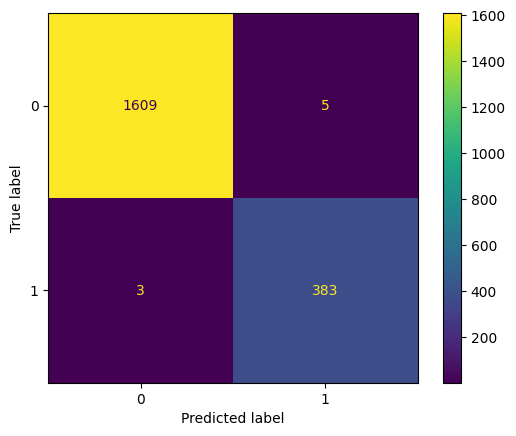

In [ ]:
evaluate_model(best_rf_model, X_test, y_test)

##**XgBoost**

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# Définition du modèle Random Forest
xg_model = XGBClassifier(random_state=42)

# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [None, 1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Recherche d'hyperparamètres avec GridSearchCV et validation croisée
grid_search = GridSearchCV(estimator=xg_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_val, y_val)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [None, 1, 2, 3],
                         'n_estimators': [10, 20, 50, 100],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

In [ ]:
# Afficher les meilleurs paramètres
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Meilleurs paramètres :", best_params)# Meilleur paramètres
print("Meilleur score : ", best_score) # Meilleur score

Meilleurs paramètres : {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9}
Meilleur score :  0.9941666666666666


In [ ]:
pd.DataFrame(grid_search.cv_results_
             ).sort_values(by='rank_test_score'
                           ).head(10) # Résultats de la recherche

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
245,0.048504,0.012948,0.012631,0.008303,0.9,0.2,None,20,1.0,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",1.0,0.995833,0.987500,0.991667,0.995833,0.994167,0.004249,1
238,0.129241,0.041470,0.009789,0.002888,0.9,0.1,3,100,0.9,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",1.0,0.991667,0.991667,0.991667,0.995833,0.994167,0.003333,1
236,0.024774,0.001731,0.004149,0.000135,0.9,0.1,3,50,1.0,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",1.0,0.991667,0.991667,0.991667,0.995833,0.994167,0.003333,1
235,0.023604,0.000216,0.003959,0.000066,0.9,0.1,3,50,0.9,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",1.0,0.991667,0.991667,0.991667,0.995833,0.994167,0.003333,1
199,0.031580,0.006009,0.004906,0.001492,0.9,0.1,None,50,0.9,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",1.0,0.991667,0.987500,0.991667,0.995833,0.993333,0.004249,5
388,0.021319,0.008049,0.003957,0.000041,1.0,0.2,None,20,0.9,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",1.0,0.991667,0.987500,0.991667,0.995833,0.993333,0.004249,5
389,0.017635,0.000348,0.004050,0.000261,1.0,0.2,None,20,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",1.0,0.991667,0.987500,0.991667,0.995833,0.993333,0.004249,5
379,0.030351,0.009436,0.004373,0.000355,1.0,0.1,3,50,0.9,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",1.0,0.987500,0.991667,0.991667,0.995833,0.993333,0.004249,5
392,0.026420,0.001114,0.004639,0.001033,1.0,0.2,None,50,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",1.0,0.995833,0.983333,0.991667,0.995833,0.993333,0.005652,5
377,0.015516,0.001296,0.004178,0.000601,1.0,0.1,3,20,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",1.0,0.991667,0.987500,0.991667,0.995833,0.993333,0.004249,5


In [ ]:
# Création du meilleur modèle avec les paramètres trouvés
best_xg_model = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)



In [ ]:
# Entraînement du modèle sur l'échantillon d'entraînement
best_xg_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Prédiction sur l'échantillon d'entraînement et de test
y_train_pred = best_xg_model.predict(X_train_resampled)
y_test_pred = best_xg_model.predict(X_test)

# Évaluation de la précision du modèle
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Précision sur l'échantillon d'entraînement :", train_accuracy)
print("Précision sur l'échantillon de test :", test_accuracy)

Précision sur l'échantillon d'entraînement : 0.9993689145329967
Précision sur l'échantillon de test : 0.9965


In [ ]:
# Matrice de confusion
conf_matrix_train = confusion_matrix(y_train_resampled, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

print("Matrice de confusion (entraînement) :\n", conf_matrix_train)
print("Matrice de confusion (test) :\n", conf_matrix_test)

Matrice de confusion (entraînement) :
 [[5539    7]
 [   0 5546]]
Matrice de confusion (test) :
 [[1609    5]
 [   2  384]]


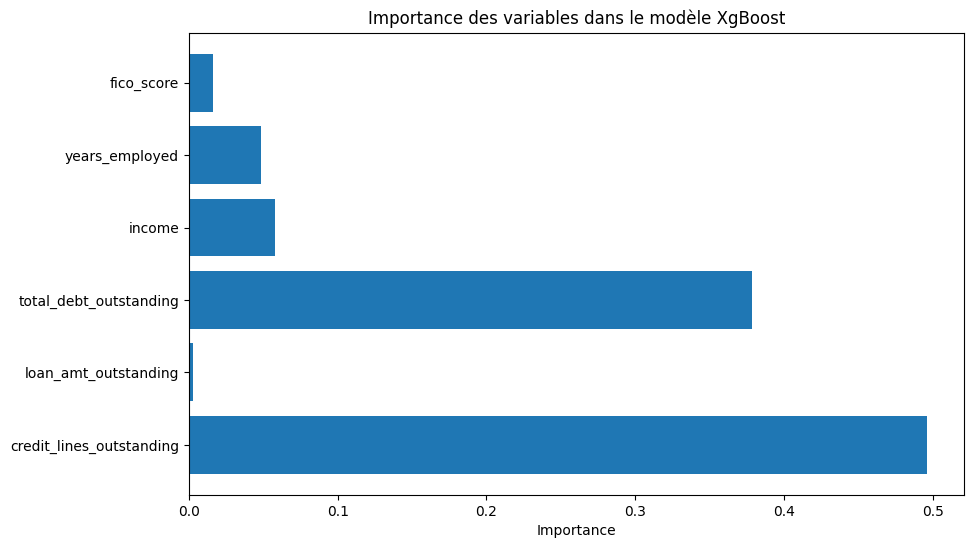

In [ ]:
# Importance des variables
feature_importances = best_xg_model.feature_importances_
features = X_train.columns

# Tracé du graphique d'importance des variables
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.title('Importance des variables dans le modèle XgBoost')
plt.show()

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1614
           1       0.99      0.99      0.99       386

    accuracy                           1.00      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       1.00      1.00      1.00      2000



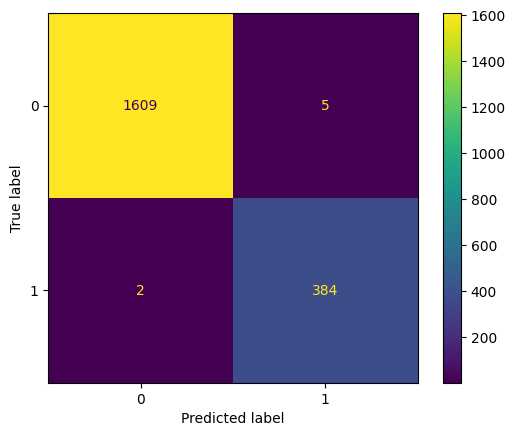

In [ ]:
evaluate_model(best_xg_model, X_test, y_test)

##**SVM**

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Définition du modèle SVC
c_svc = SVC(random_state=42)

#Tuning three kernels
params = [
    {"kernel": ["rbf"], "gamma": [0.01, 0.1,0.5,1,2], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "degree":[1,2,3,4],"C": [1, 10, 100, 1000]},
    {"kernel": ["linear"],"C": [1, 10, 100, 1000]}
]

# Recherche d'hyperparamètres avec GridSearchCV et validation croisée
grid_search = GridSearchCV(estimator=c_svc, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X_val, y_val)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.1, 0.5, 1, 2], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'degree': [1, 2, 3, 4],
                          'kernel': ['poly']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             scoring='accuracy')

In [ ]:
# Afficher les meilleurs paramètres
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Meilleurs paramètres :", best_params)# Meilleur paramètres
print("Meilleur score : ", best_score) # Meilleur score

Meilleurs paramètres : {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Meilleur score :  0.9958333333333333


In [ ]:
pd.DataFrame(grid_search.cv_results_
             ).sort_values(by='rank_test_score'
                           ).head(10) # Résultats de la recherche

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.007527,0.000596,0.002358,0.000095,1000,0.01,rbf,NaN,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",1.000000,0.995833,0.995833,0.991667,0.995833,0.995833,0.002635,1
26,0.006977,0.000725,0.002284,0.000047,10,NaN,poly,3,"{'C': 10, 'degree': 3, 'kernel': 'poly'}",1.000000,0.995833,0.995833,0.991667,0.995833,0.995833,0.002635,1
25,0.006419,0.000975,0.002231,0.000097,10,NaN,poly,2,"{'C': 10, 'degree': 2, 'kernel': 'poly'}",1.000000,1.000000,0.991667,0.991667,0.995833,0.995833,0.003727,1
38,0.008290,0.000995,0.002103,0.000084,100,NaN,linear,NaN,"{'C': 100, 'kernel': 'linear'}",1.000000,0.995833,1.000000,0.987500,0.995833,0.995833,0.004564,1
29,0.006307,0.000733,0.002080,0.000124,100,NaN,poly,2,"{'C': 100, 'degree': 2, 'kernel': 'poly'}",1.000000,0.995833,0.995833,0.991667,0.995833,0.995833,0.002635,1
32,0.007891,0.000801,0.002208,0.000108,1000,NaN,poly,1,"{'C': 1000, 'degree': 1, 'kernel': 'poly'}",1.000000,0.995833,1.000000,0.987500,0.995833,0.995833,0.004564,1
10,0.005778,0.000964,0.002262,0.000111,100,0.01,rbf,NaN,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",1.000000,1.000000,0.991667,0.987500,1.000000,0.995833,0.005270,1
39,0.007931,0.000913,0.002125,0.000097,1000,NaN,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.995833,0.995833,1.000000,0.987500,0.995833,0.995000,0.004082,8
30,0.006785,0.000469,0.002145,0.000068,100,NaN,poly,3,"{'C': 100, 'degree': 3, 'kernel': 'poly'}",0.991667,0.995833,0.995833,0.991667,0.995833,0.994167,0.002041,9
34,0.007327,0.000709,0.002436,0.000080,1000,NaN,poly,3,"{'C': 1000, 'degree': 3, 'kernel': 'poly'}",0.991667,0.995833,0.995833,0.991667,0.995833,0.994167,0.002041,9


In [ ]:
# Création du meilleur modèle avec les paramètres trouvés
best_svm_model = SVC(random_state=42, C=1, kernel='rbf', gamma = 0.01)

In [ ]:
# Entraînement du modèle sur l'échantillon d'entraînement
best_svm_model.fit(X_train_resampled, y_train_resampled)

SVC(C=1, gamma=0.01, random_state=42)

In [ ]:
# Prédiction sur l'échantillon d'entraînement et de test
y_train_pred = best_svm_model.predict(X_train_resampled)
y_test_pred = best_svm_model.predict(X_test)

# Évaluation de la précision du modèle
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Précision sur l'échantillon d'entraînement :", train_accuracy)
print("Précision sur l'échantillon de test :", test_accuracy)

Précision sur l'échantillon d'entraînement : 0.9924269743959611
Précision sur l'échantillon de test : 0.9895


In [ ]:
# Matrice de confusion
conf_matrix_train = confusion_matrix(y_train_resampled, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

print("Matrice de confusion (entraînement) :\n", conf_matrix_train)
print("Matrice de confusion (test) :\n", conf_matrix_test)

Matrice de confusion (entraînement) :
 [[5462   84]
 [   0 5546]]
Matrice de confusion (test) :
 [[1593   21]
 [   0  386]]


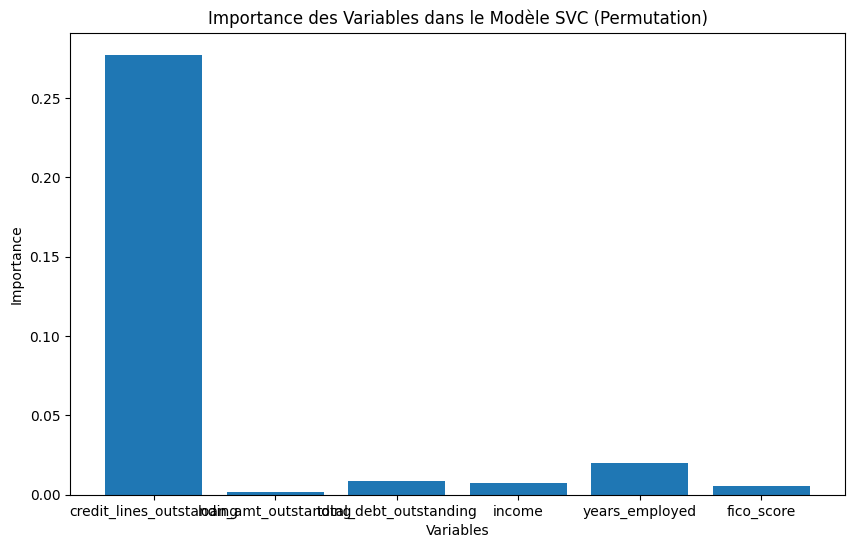

In [ ]:
from sklearn.inspection import permutation_importance

# Calcul de l'importance des caractéristiques par permutation
perm_importance = permutation_importance(best_svm_model, X_test, y_test, n_repeats=30, random_state=42)



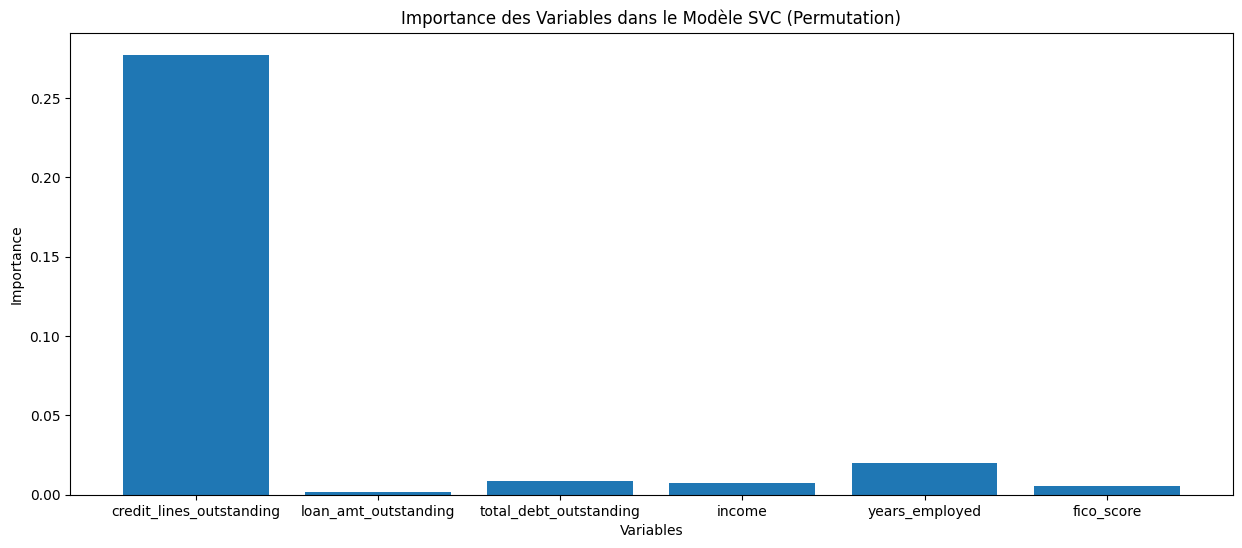

In [ ]:
# Affichage des importances des caractéristiques
features = X_train.columns

# Tracer un graphique d'importance des caractéristiques
plt.figure(figsize=(15, 6))
plt.bar(features, perm_importance.importances_mean)
plt.xticks(features)
plt.xlabel('Variables')
plt.ylabel('Importance')
plt.title('Importance des Variables dans le Modèle SVC (Permutation)')
plt.show()

Accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1614
           1       0.95      1.00      0.97       386

    accuracy                           0.99      2000
   macro avg       0.97      0.99      0.98      2000
weighted avg       0.99      0.99      0.99      2000



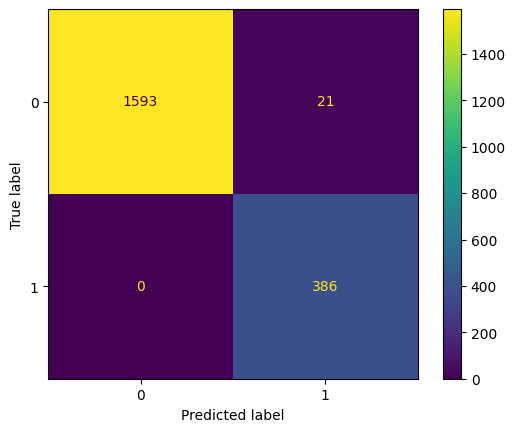

In [ ]:
evaluate_model(best_svm_model, X_test, y_test)

##**Régression logistique**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Définition des hyperparamètres à tester
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 500, 1000]
}

# Créer le modèle de régression logistique
logreg = LogisticRegression(random_state=42)

# Recherche d'hyperparamètres avec GridSearchCV et validation croisée
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_val, y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 500, 1000],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [ ]:
# Afficher les meilleurs paramètres
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Meilleurs paramètres :", best_params)# Meilleur paramètres
print("Meilleur score : ", best_score) # Meilleur score

Meilleurs paramètres : {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Meilleur score :  0.9958333333333333


In [ ]:
pd.DataFrame(grid_search.cv_results_
             ).sort_values(by='rank_test_score'
                           ).head(10) # Résultats de la recherche

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,0.019916,0.003660,0.005559,0.002958,100,1000,l2,"{'C': 100, 'max_iter': 1000, 'penalty': 'l2'}",1.000000,1.000000,0.995833,0.987500,0.995833,0.995833,0.004564,1
33,0.018945,0.001042,0.003901,0.000106,100,500,l2,"{'C': 100, 'max_iter': 500, 'penalty': 'l2'}",1.000000,1.000000,0.995833,0.987500,0.995833,0.995833,0.004564,1
31,0.021408,0.006117,0.003803,0.000202,100,100,l2,"{'C': 100, 'max_iter': 100, 'penalty': 'l2'}",1.000000,1.000000,0.995833,0.987500,0.995833,0.995833,0.004564,1
29,0.019284,0.003948,0.003811,0.000427,10,1000,l2,"{'C': 10, 'max_iter': 1000, 'penalty': 'l2'}",1.000000,1.000000,0.995833,0.987500,0.995833,0.995833,0.004564,1
27,0.016170,0.001200,0.003817,0.000215,10,500,l2,"{'C': 10, 'max_iter': 500, 'penalty': 'l2'}",1.000000,1.000000,0.995833,0.987500,0.995833,0.995833,0.004564,1
25,0.018442,0.003003,0.003840,0.000094,10,100,l2,"{'C': 10, 'max_iter': 100, 'penalty': 'l2'}",1.000000,1.000000,0.995833,0.987500,0.995833,0.995833,0.004564,1
23,0.016609,0.005698,0.003822,0.000036,1,1000,l2,"{'C': 1, 'max_iter': 1000, 'penalty': 'l2'}",1.000000,0.991667,0.991667,0.991667,1.000000,0.995000,0.004082,7
21,0.013880,0.000669,0.006416,0.003367,1,500,l2,"{'C': 1, 'max_iter': 500, 'penalty': 'l2'}",1.000000,0.991667,0.991667,0.991667,1.000000,0.995000,0.004082,7
19,0.014806,0.001191,0.003801,0.000203,1,100,l2,"{'C': 1, 'max_iter': 100, 'penalty': 'l2'}",1.000000,0.991667,0.991667,0.991667,1.000000,0.995000,0.004082,7
15,0.012883,0.001232,0.004029,0.001076,0.1,500,l2,"{'C': 0.1, 'max_iter': 500, 'penalty': 'l2'}",0.991667,0.979167,0.987500,0.995833,0.991667,0.989167,0.005652,10


In [ ]:
# Création du meilleur modèle avec les paramètres trouvés
best_logreg_model = LogisticRegression(random_state=42, C=10, max_iter = 100, penalty = 'l2')

In [ ]:
# Entraînement du modèle sur l'échantillon d'entraînement
best_logreg_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=10, random_state=42)

In [ ]:
# Prédiction sur l'échantillon d'entraînement et de test
y_train_pred = best_logreg_model.predict(X_train_resampled)
y_test_pred = best_logreg_model.predict(X_test)

# Évaluation de la précision du modèle
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Précision sur l'échantillon d'entraînement :", train_accuracy)
print("Précision sur l'échantillon de test :", test_accuracy)

Précision sur l'échantillon d'entraînement : 0.9987378290659935
Précision sur l'échantillon de test : 0.997


In [ ]:
# Matrice de confusion
conf_matrix_train = confusion_matrix(y_train_resampled, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

print("Matrice de confusion (entraînement) :\n", conf_matrix_train)
print("Matrice de confusion (test) :\n", conf_matrix_test)

Matrice de confusion (entraînement) :
 [[5535   11]
 [   3 5543]]
Matrice de confusion (test) :
 [[1609    5]
 [   1  385]]


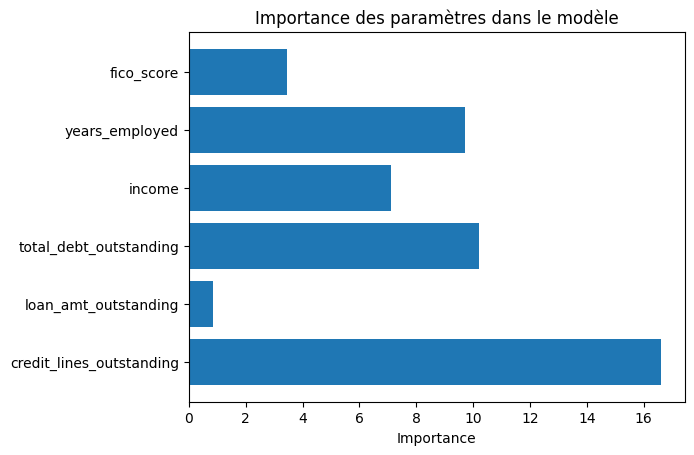

In [ ]:
# Afficher un graphique de l'importance des paramètres
feature_importance = np.abs(best_logreg_model.coef_[0])
feature_names = X_train.columns
plt.barh(feature_names, feature_importance)
plt.xlabel('Importance')
plt.title('Importance des paramètres dans le modèle de Régression logistique')
plt.show()

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1614
           1       0.99      1.00      0.99       386

    accuracy                           1.00      2000
   macro avg       0.99      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



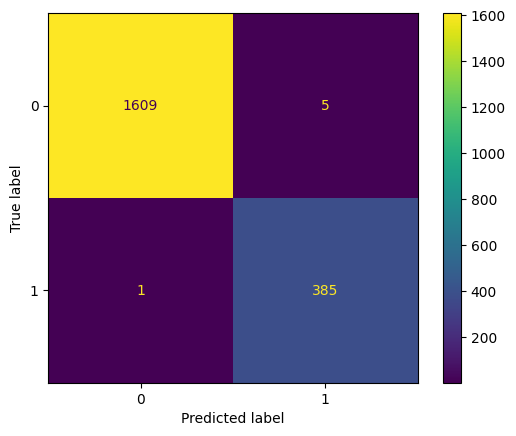

In [ ]:
evaluate_model(best_logreg_model, X_test, y_test)

##**Comparaison des performances des différents modèles**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#Renommage des modèles
random_forest = best_rf_model
XgBoost = best_xg_model
SVM = best_svm_model
Logistic_Regression = best_logreg_model

#liste de modèles
models = [random_forest, XgBoost, SVM, Logistic_Regression]

# Initialisation d'un DataFrame pour stocker les résultats
results_df = pd.DataFrame(columns=['Modèle', 'Précision (Train)', 'Précision (Test)', 'Rappel (Test)', 'F1-score (Test)'])

# Entraîner et évaluer chaque modèle
for model in models:
    model.fit(X_train_resampled, y_train_resampled)

    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test)

    model_name = type(model).__name__
    precision_train = accuracy_score(y_train_resampled, y_train_pred)
    precision_test = accuracy_score(y_test, y_test_pred)
    rappel_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)

    results_df = results_df.append({
        'Modèle': model_name,
        'Précision (Train)': precision_train,
        'Précision (Test)': precision_test,
        'Rappel (Test)': rappel_test,
        'F1-score (Test)': f1_test
    }, ignore_index=True)

# Afficher les résultats
results_df

<ipython-input-113-299dee348ca2>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-113-299dee348ca2>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-113-299dee348ca2>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-113-299dee348ca2>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


,Modèle,Précision (Train),Précision (Test),Rappel (Test),F1-score (Test)
0,RandomForestClassifier,0.999549,0.9960,0.992228,0.989664
1,XGBClassifier,0.999369,0.9965,0.994819,0.990968
2,SVC,0.992427,0.9895,1.000000,0.973518
3,LogisticRegression,0.998738,0.9970,0.997409,0.992268
